## Project: Million Playlist Dataset

## A. Data
In this project, you will implement a data processing pipeline for analyzing music playlists. We
will use the Million Playlist Dataset published by Spotify, discussed here: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge, and available to download here: https://www.kaggle.com/datasets/himanshuwagh/spotify-million/data.
The dataset contains one million playlists, where each playlist contains information about the playlist
itself (e.g., playlist title, duration) and each track it contains (e.g., track id, artist id, track name,
duration). The dataset was used as part of a “playlist continuation” challenge: given a playlist name
and a few tracks, predict which other tracks would fit best with that playlist.

## B. Tasks
In this project, you are asked to address the following tasks.
1. Present your approach to handling this big dataset. Given that the dataset is big, at about 35 GB,
you are not expected to be able to process all of it. Ideally, of course, you should have a solution
that scales to the whole dataset. Describe the approach you took and all the alternatives you
considered.
2. Present some interesting statistical/aggregate information about the dataset. Explain how you
derived the presented information.
3. Propose a definition of similarity between tracks. Specifically, given two tracks, their similarity
is a score from 0 to 1, where 0 indicates that the two tracks are not similar at all, and 1 indicates
that the two tracks are identical. Design a method to compute those similarity scores using the
dataset. Discuss the implementation and give some examples.
4. Propose a definition of similarity (score ranging from 0 to 1) between playlists. Design a method
to compute this similarity score using the dataset. Discuss the implementation and give some
examples.
5. Propose a method to solve the “playlist continuation” challenge. Discuss the implementation
and give some examples.
You should write the code in Python, and you are free to use the tools and frameworks (e.g., Spark,
Dask) that we have discussed in this course as well as others.


## Our Approach
1. Load the first slice and explore the schema (Task 0 – setup).
2. Build a random sampled DataFrame from multiple slices (Task 1).
3. Derive analytics on the sampled DataFrame (Task 2).
4. Define track similarity: 0.7 Jaccard over co-playlists + 0.3 metadata (artist/album) (Task 3).
5. Define playlist similarity: weighted Jaccard with 0.7 tracks + 0.3 artists (Task 4).
6. Implement next-track recommendation (Task 5):
   - Overlap-only neighbor retrieval (default `N_neighbors = 100`).
   - Consensus filter: keep candidates seen in at least 2 neighbors (`min_freq = 2`) with safe fallback.
   - Python engine: Phase 1 (playlist scoring) time-bounded; Phase 2 (track ranking) unlimited.
   - Spark engine: weighted hybrid reranking `Score = 0.6 * Sim(last_track, cand) + 0.4 * avg_{t∈P} Sim(t, cand)`.
7. Evaluate with Hide & Seek:
   - Selective engine flags `use_python` / `use_spark` (both True by default).
   - Use `display_test_summary(test_result)` to present results consistently.
8. Scaling plan: run the Spark engine on the full `complete_df`, compare analytics vs sample, and tune weights if needed.

## Task 0 : Initialization
1. Create and activate a conda environment (Python 3.9), then install Java and PySpark.

```bash
conda create -n pyspark_env python=3.9 -y
conda activate pyspark_env
conda install -c conda-forge openjdk=17 pyspark -y
conda install matplotlib ipykernel -y
```

2. Windows setup notes:
- Ensure a compatible JDK is available (JAVA_HOME points to JDK 17).
- If needed for local Hadoop file operations, place `winutils.exe` under `C:\hadoop\bin`.
- Configure Spark session settings in code as required (e.g., memory, shuffle partitions).

3. Get the data:
- Download the dataset (Spotify MPD Kaggle mirror) and unzip it locally.
- For faster IO, place the dataset on the local disk `C:\` rather than network storage.

In [1]:
import os
import sys
from pyspark.sql import SparkSession

# --- Windows/Local Spark Fix ---
# the worker processes use the exact same Python environment as the notebook.
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Ensure local temp directory exists for Spark
_tmp = os.environ.get("SPARK_LOCAL_DIR", "C:/temp/spark")
try:
    os.makedirs(_tmp, exist_ok=True)
except Exception:
    _tmp = "C:/temp/spark"
    os.makedirs(_tmp, exist_ok=True)

# Stable local Spark configuration
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("MPD_Project")
    # Fix for "Python worker failed to connect back" on Windows
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    # Memory and temp settings
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "2g")
    .config("spark.local.dir", _tmp)
    # Disable dynamic allocation / speculative tasks for Windows stability
    .config("spark.dynamicAllocation.enabled", "false")
    .config("spark.speculation", "false")
    # Reduce shuffle partitions for local workloads
    .config("spark.sql.shuffle.partitions", "8")
    # Reduce logging verbosity
    .config("spark.ui.showConsoleProgress", "false")
    .config("spark.eventLog.enabled", "false")
    .getOrCreate()
)

# Set log level to WARN to reduce console output
spark.sparkContext.setLogLevel("WARN")

# Quick ping to ensure session is usable
_ = spark.range(1).count()
print(f"✓ Spark session initialized (Python: {sys.executable})")

✓ Spark session initialized (Python: c:\Users\nrnor\miniconda3\envs\pyspark_env\python.exe)


## Task 0a: Load `explore_df` (first slice)

In [5]:
from pyspark.sql.functions import col, explode

BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"
file_path = os.path.join(BASE_FOLDER, "mpd.slice.0-999.json")

if os.path.exists(file_path):
    df_raw = spark.read.option("multiline", True).json(file_path)
    
    # EXPLORATION PHASE: Load ALL available variables to assess their utility
    explore_df = (
        df_raw
        .select(explode("playlists").alias("playlist"))
        .select(
            # Playlist Metadata
            col("playlist.pid").alias("playlist_id"),
            col("playlist.name").alias("playlist_name"),
            col("playlist.description").alias("playlist_description"),
            col("playlist.num_followers").alias("num_followers"),
            col("playlist.num_edits").alias("num_edits"),
            col("playlist.modified_at").alias("modified_at"),
            col("playlist.collaborative").alias("is_collaborative"),
            col("playlist.duration_ms").alias("playlist_duration_ms"),
            
            # Track Metadata (Exploded)
            explode("playlist.tracks").alias("track")
        )
        .select(
            # Keep all playlist info
            col("playlist_id"),
            col("playlist_name"),
            col("playlist_description"),
            col("num_followers"),
            col("num_edits"),
            col("modified_at"),
            col("is_collaborative"),
            col("playlist_duration_ms"),
            
            # Keep all track info
            col("track.pos").alias("track_position"),
            col("track.track_name").alias("track_name"),
            col("track.track_uri").alias("track_uri"),
            col("track.artist_name").alias("artist_name"),
            col("track.artist_uri").alias("artist_uri"),
            col("track.album_name").alias("album_name"),
            col("track.album_uri").alias("album_uri"),
            col("track.duration_ms").alias("duration_ms")
        )
    )

    print(f"✓ Dataset loaded (FULL SCHEMA): {explore_df.count()} tracks")
else:
    print(f"ERROR: File not found at {file_path}")

✓ Dataset loaded (FULL SCHEMA): 67503 tracks


## Task 0b: Analyze structure and select variables from `explore_df`

In [9]:
# Analyze explore_df structure and make variable selection decisions
from pyspark.sql.functions import count, col, isnan, when

print("=== Schema & Structure ===")
explore_df.printSchema()
total_rows = explore_df.count()
print(f"\nTotal rows (tracks): {total_rows:,}")

print("\n=== Variable Selection Analysis ===")
print("\nCalculating missingness and variability for each variable:")

# Calculate actual missing values
desc_null = explore_df.filter(col('playlist_description').isNull()).count()
desc_null_pct = (desc_null / total_rows) * 100

followers_null = explore_df.filter(col('num_followers').isNull()).count()
followers_distinct = explore_df.select('num_followers').distinct().count()
followers_ones = explore_df.filter(col('num_followers') == 1).count()
followers_ones_pct = (followers_ones / (total_rows - followers_null)) * 100 if total_rows > followers_null else 0

collab_true = explore_df.filter(col('is_collaborative') == True).count()
collab_true_pct = (collab_true / total_rows) * 100

track_uri_distinct = explore_df.select('track_uri').distinct().count()
artist_uri_distinct = explore_df.select('artist_uri').distinct().count()
album_uri_distinct = explore_df.select('album_uri').distinct().count()

# Get track_position min/max using basic Python
track_pos_stats = explore_df.select('track_position').toPandas()
track_pos_min = int(track_pos_stats['track_position'].min())
track_pos_max = int(track_pos_stats['track_position'].max())

print(f"\n  DROPPED (poor signal):")
print(f"    ✗ playlist_description: {desc_null:,} nulls ({desc_null_pct:.1f}%) → insufficient information")
print(f"    ✗ num_followers: {followers_ones:,} playlists with exactly 1 ({followers_ones_pct:.1f}%) → heavily skewed")
print(f"    ✗ is_collaborative: {collab_true:,} playlists true ({collab_true_pct:.2f}%) → extremely rare")
print(f"    ✗ num_edits, modified_at: low variability, temporal artifacts → reproducibility issues")

print(f"\n  KEPT (strong signal):")
print(f"    ✓ track_uri: {track_uri_distinct:,} unique values (good diversity)")
print(f"    ✓ artist_uri: {artist_uri_distinct:,} unique values")
print(f"    ✓ album_uri: {album_uri_distinct:,} unique values")
print(f"    ✓ track_position: {track_pos_min} to {track_pos_max} (preserves order)")
print(f"    ✓ track_name, artist_name, album_name: metadata for content-based similarity")
print(f"    ✓ duration_ms: temporal feature")

print(f"\n=== Selected Features (10 columns) ===")
selected_cols = [
    'playlist_id', 'playlist_name', 'track_position',
    'track_uri', 'track_name', 'artist_uri', 'artist_name',
    'album_uri', 'album_name', 'duration_ms'
]
for col_name in selected_cols:
    print(f"  ✓ {col_name}")

print(f"\n✓ Conclusion: {len(selected_cols)} features selected; schema validated; ready for sampling.")

=== Schema & Structure ===
root
 |-- playlist_id: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_description: string (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- num_edits: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- is_collaborative: string (nullable = true)
 |-- playlist_duration_ms: long (nullable = true)
 |-- track_position: long (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- duration_ms: long (nullable = true)


Total rows (tracks): 67,503

=== Variable Selection Analysis ===

Calculating missingness and variability for each variable:

Total rows (tracks): 67,503

=== Variable Selection Analysis ===

Calculating missingness and variability for each variable:

  DROPPED (poor sig

## Task 1: Load sampled DataFrame (`sample_df`)

> Reflection:
> - How can we handle the dataset to minimize compute time and sampling bias?
> - What do we know about the slices? Are they composed of random playlists or is there any ordering/grouping?
>
> Sampling strategies:
> 1. Method 1: Select every n-th slice (deterministic)
> 2. Method 2: Select k slices randomly
> 3. Method 3: Select k random slices, then sample up to N random playlists
>
> Variable selection (from Task 0 analysis):
> - Dropped: `playlist_description` (98% missing), `num_followers` (mostly 1), `num_edits`, `modified_at`, `is_collaborative` (very rare).
> - Kept: `track_uri`, `artist_uri`, `album_uri`, `track_position`, `duration_ms`.

## Task 1a: Helpers for sampling and loading

In [10]:
# --- Helpers: slice listing, reading, playlist/track transforms ---
import glob
import random
from pyspark.sql import functions as F

def list_slices(base_folder, pattern="mpd.slice.*.json"):
    """Return sorted list of slice file paths."""
    return sorted(glob.glob(f"{base_folder}/{pattern}"))

def read_slices(slices):
    """Read one or many JSON slice files into a Spark DataFrame."""
    return spark.read.option("multiline", "true").json(slices)

def playlists_df_from_raw(df_raw):
    """Explode raw df into one row per playlist, keeping nested tracks."""
    return df_raw.select(F.explode("playlists").alias("playlist")) \
                 .select(
                     F.col("playlist.pid").alias("playlist_id"),
                     F.col("playlist.name").alias("playlist_name"),
                     F.col("playlist.tracks").alias("tracks")
                 )

def tracks_df_from_playlists(playlists_df):
    """Explode playlist-level df into one row per track (tracks-level)."""
    return playlists_df.select(
            F.col("playlist_id"), 
            F.col("playlist_name"), 
            F.explode("tracks").alias("track")
        ).select(
           "playlist_id",
           "playlist_name",
           F.col("track.pos").alias("track_position"),
           F.col("track.track_name").alias("track_name"),
           F.col("track.track_uri").alias("track_uri"),
           F.col("track.artist_name").alias("artist_name"),
           F.col("track.artist_uri").alias("artist_uri"),
           F.col("track.album_name").alias("album_name"),
           F.col("track.album_uri").alias("album_uri"),
           F.col("track.duration_ms").alias("duration_ms")
       )

def random_choose_slices(slice_files, k, seed=42):
    random.seed(seed)
    return random.sample(slice_files, min(k, len(slice_files)))

#### Method 1: Select every n-th slice (deterministic)

In [11]:
# Method 1 : Deterministic every-nth slices sampling

# Parameters
NTH = 10  # take every NTH slice
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

slice_files = list_slices(BASE_FOLDER)
sample_files = slice_files[::NTH]
print(f"Method 1: taking every {NTH}th slice → {len(sample_files)} files")

# Read and flatten to playlist-level
df_raw = read_slices(sample_files)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
M1_sample_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostic
print(f"M1_sample_df ready (tracks-level). Example rows:")
M1_sample_df.show(5, truncate=False)


Method 1: taking every 10th slice → 100 files
M1_sample_df ready (tracks-level). Example rows:
M1_sample_df ready (tracks-level). Example rows:
+-----------+-------------+--------------+-----------------------------+------------------------------------+--------------------+-------------------------------------+--------------------------------+------------------------------------+-----------+
|playlist_id|playlist_name|track_position|track_name                   |track_uri                           |artist_name         |artist_uri                           |album_name                      |album_uri                           |duration_ms|
+-----------+-------------+--------------+-----------------------------+------------------------------------+--------------------+-------------------------------------+--------------------------------+------------------------------------+-----------+
|675000     |Light        |0             |Union - Groove Mix           |spotify:track:3Ko5oOHlziMVcfr5N

#### Method 2: Random slices

In [12]:
# Method 2 : Random slices sampling

# Parameters
k = 100   # number of slices to pick
SEED = 42
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

# List slices and choose randomly
slice_files = list_slices(BASE_FOLDER)
chosen = random_choose_slices(slice_files, k, seed=SEED)
print(f"Chosen {len(chosen)} slices (out of {len(slice_files)})")

# Read chosen slices and flatten to playlist-level
df_raw = read_slices(chosen)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
M2_sample_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostic
print("M2_sample_df ready (tracks-level). Example rows:")
M2_sample_df.show(5, truncate=False)

Chosen 100 slices (out of 1000)
M2_sample_df ready (tracks-level). Example rows:
M2_sample_df ready (tracks-level). Example rows:
+-----------+-------------+--------------+-------------------------------+------------------------------------+-----------------+-------------------------------------+-------------------------------+------------------------------------+-----------+
|playlist_id|playlist_name|track_position|track_name                     |track_uri                           |artist_name      |artist_uri                           |album_name                     |album_uri                           |duration_ms|
+-----------+-------------+--------------+-------------------------------+------------------------------------+-----------------+-------------------------------------+-------------------------------+------------------------------------+-----------+
|300000     |April 2017   |0             |Cold Heart Killer              |spotify:track:1IPfImi6ZtZlZo90xPigfM|Lia Marie Jo

#### Method 3: Random slices + random playlists

In [13]:
# Method 3 : Random slices + random playlists sampling

# Parameters
K_SLICES = 200   # number of slices to randomly load
N_PLAYLISTS = 100000  # target playlists
SEED = 42
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

slice_files = list_slices(BASE_FOLDER)
chosen = random_choose_slices(slice_files, K_SLICES, seed=SEED)
print(f"Method 3: choose {len(chosen)} random slices")

# Read chosen slices and flatten to playlists-level
df_raw = read_slices(chosen)
playlists_df = playlists_df_from_raw(df_raw)

# Use sample() instead of orderBy to avoid shuffle issues
sample_fraction = min(1.0, N_PLAYLISTS / playlists_df.count() * 1.2)  # 20% buffer
sample_playlists = playlists_df.sample(fraction=sample_fraction, seed=SEED).limit(N_PLAYLISTS)

# Flatten to tracks-level and cache
M3_sample_df = tracks_df_from_playlists(sample_playlists).cache()

# Minimal diagnostics
print("M3_sample_df ready (tracks-level).")
print(f"Total playlists sampled: {M3_sample_df.select('playlist_id').distinct().count()}")
print(f"Total tracks: {M3_sample_df.count()}")


Method 3: choose 200 random slices
M3_sample_df ready (tracks-level).
M3_sample_df ready (tracks-level).
Total playlists sampled: 100000
Total tracks: 6689682
Total playlists sampled: 100000
Total tracks: 6689682


#### Compare samples

SAMPLING METHODS COMPARISON

                         Method  Total Tracks  Unique Playlists  Unique Artists  Unique Tracks  Avg Playlist Size
          M1 (Every 10th slice)       6633713            100000          108537         669453           66.33713
         M2 (100 random slices)       6624113            100000          108479         671849           66.24113
M3 (200 slices, 100k playlists)       6689682            100000          108113         673189           66.89682

                         Method  Total Tracks  Unique Playlists  Unique Artists  Unique Tracks  Avg Playlist Size
          M1 (Every 10th slice)       6633713            100000          108537         669453           66.33713
         M2 (100 random slices)       6624113            100000          108479         671849           66.24113
M3 (200 slices, 100k playlists)       6689682            100000          108113         673189           66.89682


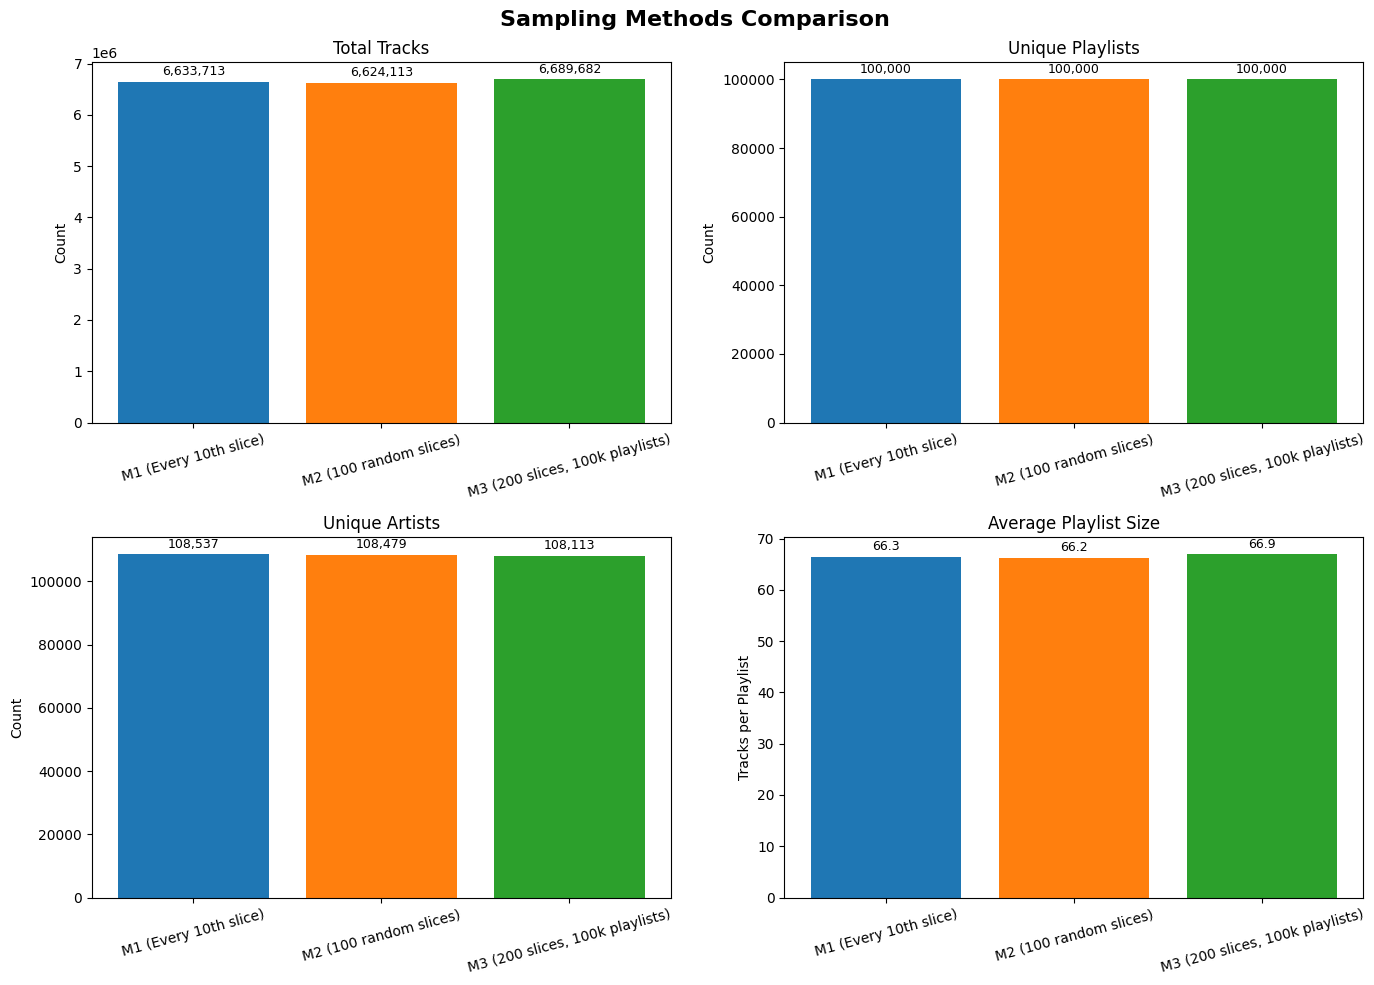


COVERAGE ANALYSIS (vs. Complete Dataset)

Dataset totals: 1,000,000 playlists | 295,860 artists | 2,262,292 tracks

M1 (Every 10th slice):
  Playlists: 100,000 (10.00%)
  Artists: 108,537 (36.69%)
  Tracks: 6,633,713 (9.999%)
  Diversity: 16.4 artists per 1000 tracks

M2 (100 random slices):
  Playlists: 100,000 (10.00%)
  Artists: 108,479 (36.67%)
  Tracks: 6,624,113 (9.984%)
  Diversity: 16.4 artists per 1000 tracks

M3 (200 slices, 100k playlists):
  Playlists: 100,000 (10.00%)
  Artists: 108,113 (36.54%)
  Tracks: 6,689,682 (10.083%)
  Diversity: 16.2 artists per 1000 tracks

✓ Comparison complete. Method recommendations:
Given the similarities in coverage for the same # playlists, we'll use sampling method M3 for our experiments even though its computing time was a bit longer initially.


In [14]:
# Quick comparison of sampling methods (M1, M2, M3)
from pyspark.sql.functions import count, countDistinct, avg, col

print("=" * 80)
print("SAMPLING METHODS COMPARISON")
print("=" * 80)

# Define samples to compare
samples = [
    ("M1 (Every 10th slice)", M1_sample_df),
    ("M2 (100 random slices)", M2_sample_df),
    ("M3 (200 slices, 100k playlists)", M3_sample_df)
]

# Collect metrics for each sample
comparison_data = []
for name, df in samples:
    metrics = {
        "Method": name,
        "Total Tracks": df.count(),
        "Unique Playlists": df.select("playlist_id").distinct().count(),
        "Unique Artists": df.select("artist_name").distinct().count(),
        "Unique Tracks": df.select("track_name", "artist_name").distinct().count(),
        "Avg Playlist Size": df.groupBy("playlist_id").agg(count("*").alias("size")).agg(avg("size")).collect()[0][0]
    }
    comparison_data.append(metrics)

# Display comparison table
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Visual comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sampling Methods Comparison', fontsize=16, fontweight='bold')

# Total tracks comparison
ax = axes[0, 0]
ax.bar(comparison_df['Method'], comparison_df['Total Tracks'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Total Tracks')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Total Tracks']):
    ax.text(i, v + max(comparison_df['Total Tracks'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Unique playlists comparison
ax = axes[0, 1]
ax.bar(comparison_df['Method'], comparison_df['Unique Playlists'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Unique Playlists')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Unique Playlists']):
    ax.text(i, v + max(comparison_df['Unique Playlists'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Unique artists comparison
ax = axes[1, 0]
ax.bar(comparison_df['Method'], comparison_df['Unique Artists'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Unique Artists')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Unique Artists']):
    ax.text(i, v + max(comparison_df['Unique Artists'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Average playlist size comparison
ax = axes[1, 1]
ax.bar(comparison_df['Method'], comparison_df['Avg Playlist Size'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Tracks per Playlist')
ax.set_title('Average Playlist Size')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Avg Playlist Size']):
    ax.text(i, v + max(comparison_df['Avg Playlist Size'])*0.02, f"{v:.1f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# True coverage analysis (values from kaggle/stats.txt)
TOTAL_PLAYLISTS = 1_000_000
TOTAL_TRACKS = 66_346_428
TOTAL_UNIQUE_TRACKS = 2_262_292
TOTAL_UNIQUE_ARTISTS = 295_860
TOTAL_UNIQUE_ALBUMS = 734_684

print("\n" + "=" * 80)
print("COVERAGE ANALYSIS (vs. Complete Dataset)")
print("=" * 80)
print(f"\nDataset totals: {TOTAL_PLAYLISTS:,} playlists | {TOTAL_UNIQUE_ARTISTS:,} artists | {TOTAL_UNIQUE_TRACKS:,} tracks")

for i, row in comparison_df.iterrows():
    print(f"\n{row['Method']}:")
    print(f"  Playlists: {row['Unique Playlists']:,} ({row['Unique Playlists']/TOTAL_PLAYLISTS*100:.2f}%)")
    print(f"  Artists: {row['Unique Artists']:,} ({row['Unique Artists']/TOTAL_UNIQUE_ARTISTS*100:.2f}%)")
    print(f"  Tracks: {row['Total Tracks']:,} ({row['Total Tracks']/TOTAL_TRACKS*100:.3f}%)")
    diversity_ratio = (row['Unique Artists'] / row['Total Tracks']) * 1000
    print(f"  Diversity: {diversity_ratio:.1f} artists per 1000 tracks")

print("\n✓ Comparison complete. Method recommendations:")
print("Given the similarities in coverage for the same # playlists, we'll use sampling method M3 for our experiments even though its computing time was a bit longer initially.")

## Task 2: Main analytics (run on selected sample M3)


ANALYTICS ON M3_sample_df

=== Dataset Overview ===
Total tracks: 6,689,682
Unique playlists: 100,000
Unique playlists: 100,000
Unique artists: 108,113
Unique artists: 108,113
Unique tracks (by name+artist): 673,189
Unique tracks (by name+artist): 673,189
Unique track URIs: 687,833

=== Top 10 Artists ===
Unique track URIs: 687,833

=== Top 10 Artists ===
+--------------+-----------+
|artist_name   |track_count|
+--------------+-----------+
|Drake         |83749      |
|Kanye West    |41776      |
|Kendrick Lamar|35505      |
|Rihanna       |33743      |
|Eminem        |31157      |
|The Weeknd    |30922      |
|Ed Sheeran    |26917      |
|Future        |24797      |
|J. Cole       |24548      |
|Justin Bieber |24142      |
+--------------+-----------+


=== Playlist Size Stats ===
+--------------+-----------+
|artist_name   |track_count|
+--------------+-----------+
|Drake         |83749      |
|Kanye West    |41776      |
|Kendrick Lamar|35505      |
|Rihanna       |33743      |
|E

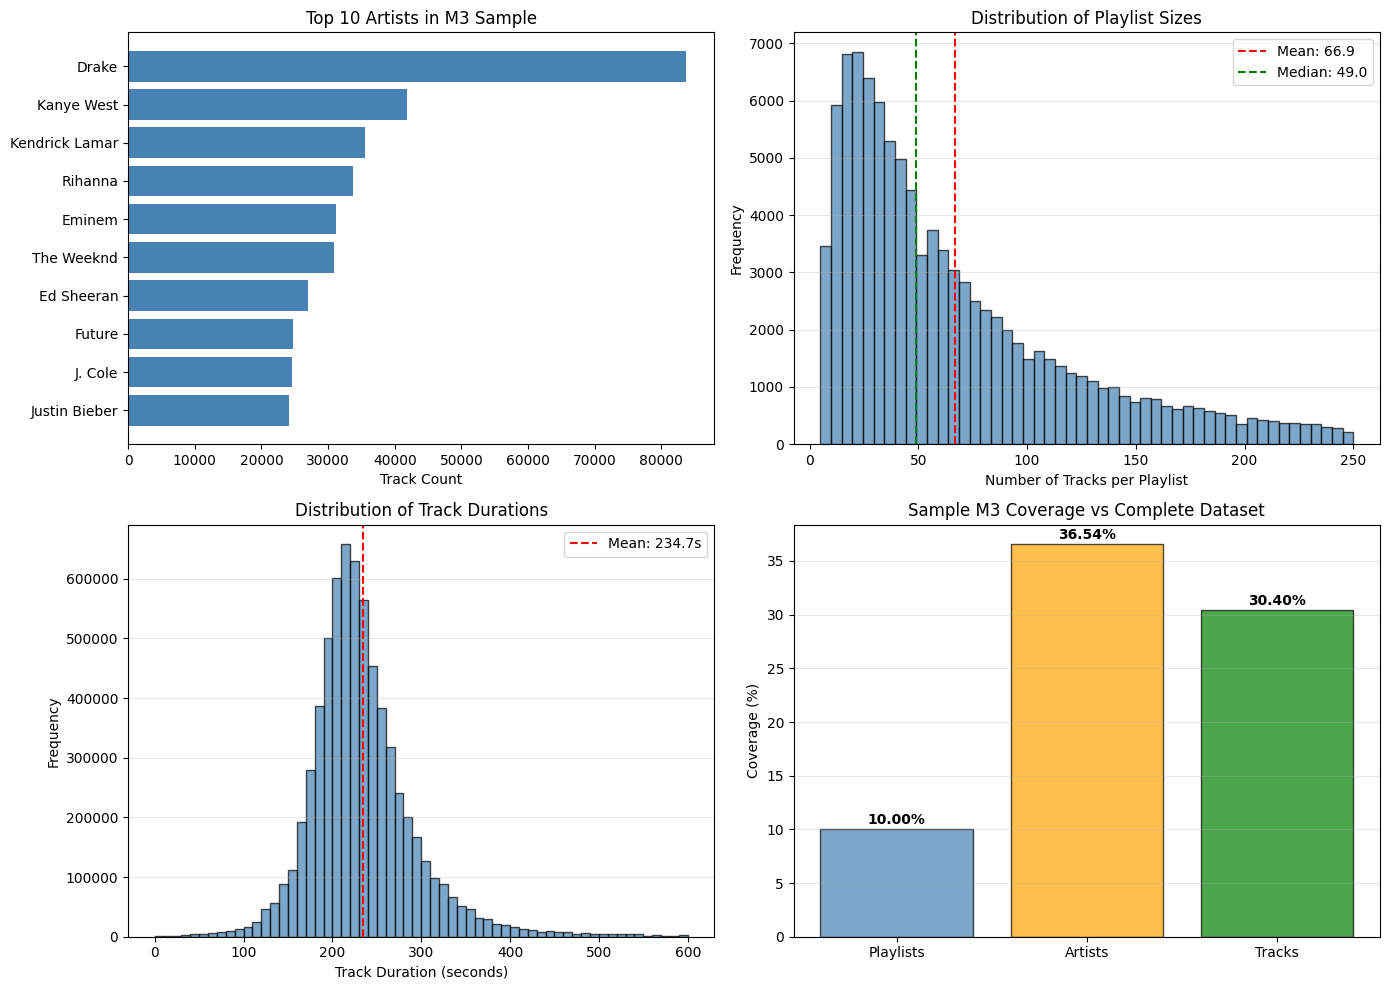


=== Coverage Summary ===
Playlists: 100,000 / 1,000,000 (10.00%)
Artists: 108,113 / 295,860 (36.54%)
Tracks: 687,833 / 2,262,292 (30.40%)
✓ M3 sample is representative and ready for modeling.


In [15]:
# === Analytics on M3_sample_df ===
# Detailed exploration and visualization of the selected sample
from pyspark.sql.functions import count, avg, col
import matplotlib.pyplot as plt
import pandas as pd

print("\n" + "="*80)
print("ANALYTICS ON M3_sample_df")
print("="*80)

print("\n=== Dataset Overview ===")
print(f"Total tracks: {M3_sample_df.count():,}")
print(f"Unique playlists: {M3_sample_df.select('playlist_id').distinct().count():,}")
print(f"Unique artists: {M3_sample_df.select('artist_name').distinct().count():,}")
print(f"Unique tracks (by name+artist): {M3_sample_df.select('track_name', 'artist_name').distinct().count():,}")
print(f"Unique track URIs: {M3_sample_df.select('track_uri').distinct().count():,}")

# Top artists by frequency
print("\n=== Top 10 Artists ===")
top_artists = M3_sample_df.groupBy("artist_name") \
    .agg(count("*").alias("track_count")) \
    .orderBy(col("track_count").desc()) \
    .limit(10)
top_artists.show(truncate=False)

# Playlist size distribution
print("\n=== Playlist Size Stats ===")
playlist_sizes = M3_sample_df.groupBy("playlist_id") \
    .agg(count("*").alias("num_tracks"))
playlist_sizes.describe("num_tracks").show()

# Track duration analysis
print("\n=== Track Duration Stats (ms) ===")
M3_sample_df.select("duration_ms").describe().show()

# === Visualizations ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Top 10 artists
top_artists_pd = top_artists.toPandas()
axes[0, 0].barh(top_artists_pd['artist_name'], top_artists_pd['track_count'], color='steelblue')
axes[0, 0].set_xlabel('Track Count')
axes[0, 0].set_title('Top 10 Artists in M3 Sample')
axes[0, 0].invert_yaxis()

# 2. Playlist size distribution
playlist_sizes_pd = playlist_sizes.toPandas()
axes[0, 1].hist(playlist_sizes_pd['num_tracks'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(playlist_sizes_pd['num_tracks'].mean(), color='red', linestyle='--', label=f"Mean: {playlist_sizes_pd['num_tracks'].mean():.1f}")
axes[0, 1].axvline(playlist_sizes_pd['num_tracks'].median(), color='green', linestyle='--', label=f"Median: {playlist_sizes_pd['num_tracks'].median():.1f}")
axes[0, 1].set_xlabel('Number of Tracks per Playlist')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Playlist Sizes')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Track duration distribution
duration_pd = M3_sample_df.select("duration_ms").toPandas()
duration_pd['duration_sec'] = duration_pd['duration_ms'] / 1000
axes[1, 0].hist(duration_pd['duration_sec'], bins=60, range=(0, 600), edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].axvline(duration_pd['duration_sec'].mean(), color='red', linestyle='--', label=f"Mean: {duration_pd['duration_sec'].mean():.1f}s")
axes[1, 0].set_xlabel('Track Duration (seconds)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Track Durations')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Coverage vs complete dataset
TOTAL_PLAYLISTS = 1_000_000
TOTAL_UNIQUE_ARTISTS = 295_860
TOTAL_UNIQUE_TRACKS = 2_262_292

sample_playlists = M3_sample_df.select('playlist_id').distinct().count()
sample_artists = M3_sample_df.select('artist_name').distinct().count()
sample_tracks = M3_sample_df.select('track_uri').distinct().count()

coverage = [
    (sample_playlists / TOTAL_PLAYLISTS * 100, 'Playlists'),
    (sample_artists / TOTAL_UNIQUE_ARTISTS * 100, 'Artists'),
    (sample_tracks / TOTAL_UNIQUE_TRACKS * 100, 'Tracks')
]
coverage_pct = [x[0] for x in coverage]
coverage_names = [x[1] for x in coverage]

axes[1, 1].bar(coverage_names, coverage_pct, color=['steelblue', 'orange', 'green'], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Coverage (%)')
axes[1, 1].set_title('Sample M3 Coverage vs Complete Dataset')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(coverage_pct):
    axes[1, 1].text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== Coverage Summary ===")
print(f"Playlists: {sample_playlists:,} / {TOTAL_PLAYLISTS:,} ({sample_playlists/TOTAL_PLAYLISTS*100:.2f}%)")
print(f"Artists: {sample_artists:,} / {TOTAL_UNIQUE_ARTISTS:,} ({sample_artists/TOTAL_UNIQUE_ARTISTS*100:.2f}%)")
print(f"Tracks: {sample_tracks:,} / {TOTAL_UNIQUE_TRACKS:,} ({sample_tracks/TOTAL_UNIQUE_TRACKS*100:.2f}%)")
print(f"✓ M3 sample is representative and ready for modeling.")

## Task 3: Define track similarity scoring function

#### Approach: Hybrid Similarity Score
To quantify the similarity between two tracks ($t_1, t_2$), we propose a **Weighted Hybrid Score** that combines **User Behavior (Context)** and **Metadata (Content)**.

$$ Score(t_1, t_2) = \alpha \cdot Sim_{context}(t_1, t_2) + (1 - \alpha) \cdot Sim_{content}(t_1, t_2) $$

We chose $\alpha = 0.7$ to prioritize user behavior, as co-occurrence in playlists is a stronger signal of "vibe" similarity than raw metadata.

##### 1. Context Similarity (Jaccard Index)
We measure how often two tracks appear together in the same playlists relative to their total appearances. This normalizes for popularity (avoiding the "Drake effect" where popular tracks co-occur with everything).

$$ J(t_1, t_2) = \frac{|P(t_1) \cap P(t_2)|}{|P(t_1) \cup P(t_2)|} $$

Where $P(t)$ is the set of Playlist IDs containing track $t$.

##### 2. Content Similarity (Metadata)
We use a simple rule-based score to boost tracks that share metadata attributes. This helps with the "Cold Start" problem for rare tracks.
*   **Same Artist:** +0.5
*   **Same Album:** +0.3
*   *(Normalized to range 0-1)*

##### 3. Implementation Strategy
Computing $N^2$ pairs is impossible for 2M+ tracks. We use an **Inverted Index** approach:
1.  **Build Profiles (`build_track_profiles`):** We aggregate the dataset once to create a global `track_profiles` DataFrame. This acts as a lookup table mapping `Track_URI -> {Set<Playlist_IDs>, Artist_URI, Album_URI}`.
2.  **On-Demand Calculation (`calculate_track_score`):** The scoring function takes two Track URIs, retrieves their profiles from the global DataFrame, and computes the score instantly. This keeps the function signature simple and efficient.

In [16]:
from pyspark.sql import functions as F

# 1. Define Profile Builder
def build_track_profiles(df):
    """
    Aggregates track data to create profiles containing:
    - Context: List of playlists it appears in
    - Content: Artist URI, Album URI, Track Name, Artist Name
    """
    return df.groupBy("track_uri").agg(
        F.collect_set("playlist_id").alias("playlist_ids"),
        F.first("artist_uri").alias("artist_uri"),
        F.first("album_uri").alias("album_uri"),
        F.first("track_name").alias("track_name"),
        F.first("artist_name").alias("artist_name")
    ).cache()

# 2. Build and Store Profiles
track_profiles = build_track_profiles(M3_sample_df)
print(f"Track profiles built for {track_profiles.count()} unique tracks.")

# 3. Define Scoring Function
def calculate_track_score(track1_uri, track2_uri):
    """
    Calculates similarity score between two tracks using the global track_profiles DataFrame.
    Returns ONLY the final weighted score (float).
    """
    # A. Fetch Profiles
    # We look up both tracks in the global track_profiles DataFrame
    rows = track_profiles.filter(F.col("track_uri").isin([track1_uri, track2_uri])).collect()
    
    if len(rows) < 2:
        # If we can't find both tracks (or if same track passed and only 1 row returned), return 0
        if len(rows) == 1 and track1_uri == track2_uri:
            p1 = rows[0]; p2 = rows[0]
        else:
            return 0.0
    else:
        p1 = next(r for r in rows if r["track_uri"] == track1_uri)
        p2 = next(r for r in rows if r["track_uri"] == track2_uri)

    # B. Context Similarity (Jaccard)
    set1 = set(p1["playlist_ids"])
    set2 = set(p2["playlist_ids"])
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_score = intersection / union if union > 0 else 0.0
    
    # C. Content Similarity (Metadata)
    meta_score = 0.0
    if p1["artist_uri"] == p2["artist_uri"]:
        meta_score += 0.5
    if p1["album_uri"] == p2["album_uri"]:
        meta_score += 0.3
    
    # D. Weighted Hybrid Score
    # Weights: 70% Jaccard, 30% Metadata (normalized)
    hybrid_score = (0.7 * jaccard_score) + (0.3 * (meta_score / 0.8))
    
    return round(hybrid_score, 4)

Track profiles built for 687833 unique tracks.


### Examples for track similarity

In [17]:
# Test with two tracks
sample_tracks = M3_sample_df.limit(5).collect()
t1_uri = sample_tracks[0]["track_uri"]
t2_uri = sample_tracks[1]["track_uri"]

# Calculate score directly using URIs (uses global track_profiles)
score = calculate_track_score(t1_uri, t2_uri)

# Fetch details just for printing the names in the example
p1 = track_profiles.filter(F.col("track_uri") == t1_uri).first()
p2 = track_profiles.filter(F.col("track_uri") == t2_uri).first()

# Manually calculate context info for display
set1 = set(p1["playlist_ids"])
set2 = set(p2["playlist_ids"])
common = len(set1.intersection(set2))
total_unique = len(set1.union(set2))

print(f"Track 1: {p1['artist_name']} - {p1['track_name']}")
print(f"Track 2: {p2['artist_name']} - {p2['track_name']}")
print(f"Similarity Score: {score}")
print(f"Context Info: Appears in {len(set1)} & {len(set2)} playlists. Common: {common}. Union (total_unique): {total_unique}")

Track 1: Foxygen - San Francisco
Track 2: Beach House - Space Song
Similarity Score: 0.0107
Context Info: Appears in 114 & 283 playlists. Common: 6. Union (total_unique): 391


### Task 3 bis: The co-occurrence matrix feature approach and proposed solution
Summary of the approach:
- Instead of only looking at two tracks in isolation, link each track with every other track.
- Build an n×n co-occurrence matrix where n is the number of tracks; each value counts how many playlists contain both tracks.
- The matrix is symmetric; the diagonal is trivial; and most entries will be 0.
- Computing this for the full dataset is infeasible (≈ 2.26M tracks ⇒ trillions of pairs).

To reduce computation, we can eliminate 0s as much as possible using the inverted index (track profiles) and ignore tracks appearing only once.

In our `M3_sample_df` example:
- Total tracks (unique rows in `track_popularity`): 687,833
- Tracks appearing only once: 382,883
- Remaining candidates (appear ≥ 2 times): ~304,950
- Even then, pair counts are massive.

Practical alternative: on-demand co-occurrence limited to candidates of interest
- Feed the tested playlist and extract n tracks.
- Find similar candidate playlists via overlap on tracks & artists.
- Extract m candidate tracks from these playlists.
- Apply a frequency filter (e.g., drop candidates seen only once across neighbors) - acceptable given the distribution displayed below.
- Compute a local similarity score only for these n×m pairs:
     $$Score = \sum_{t \in P_{target}} Sim(t, Candidate)$$

Then later in the recommendation we use a 2nd weighted hybrid score (implemented in Spark engine only):
     $$Score(c) = w_1 \cdot Sim(c, LastTrack) + w_2 \cdot \frac{1}{|P|} \sum_{t \in P} Sim(c, t)$$

total_tracks : 687833
Tracks appearing in exactly 1 playlist: 382,883 (55.67%)
Tracks appearing in multiple playlists: 304,950 (44.33%)


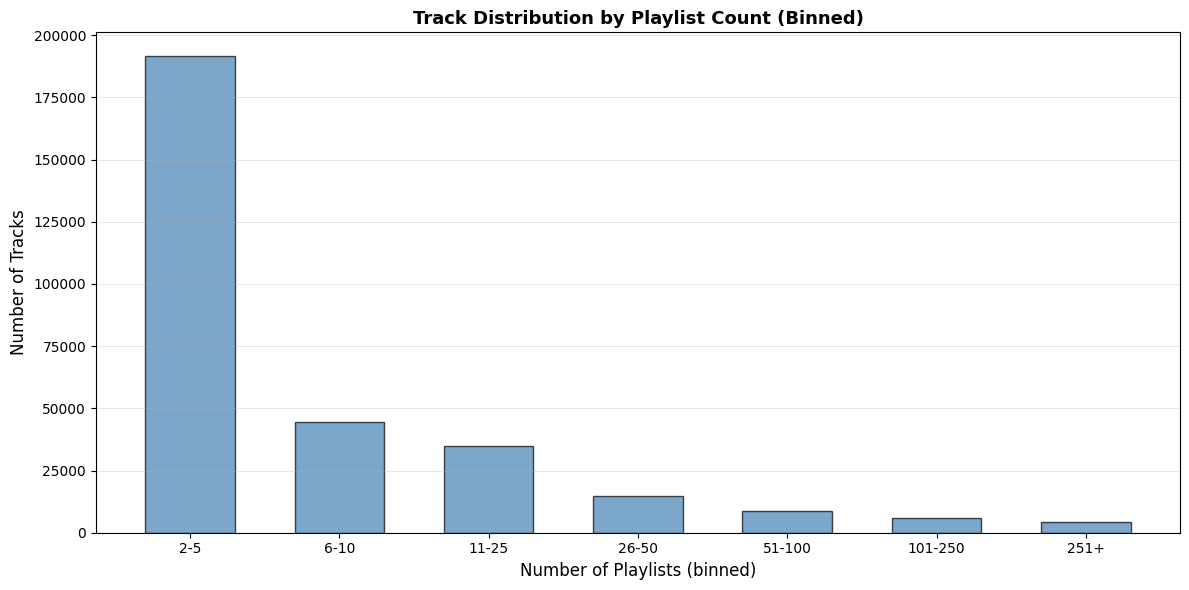

In [18]:
# Track popularity analysis: tracks appearing 1x vs multiple times
# Extract playlist count for each track from track_profiles
track_popularity = track_profiles.select(
    "track_uri",
    "track_name",
    "artist_name",
    F.size("playlist_ids").alias("playlist_count")
).cache()

# Store tracks that appear only once and multiple times
tracks_once = track_popularity.filter(F.col("playlist_count") == 1).orderBy(F.col("track_name"))
tracks_multiple = track_popularity.filter(F.col("playlist_count") > 1).orderBy(F.col("playlist_count").desc(), F.col("track_name"))

# Get counts
count_once = tracks_once.count()
count_multiple = tracks_multiple.count()
total_tracks = track_popularity.count()

# Display the 2 numbers
print("=" * 80)
print(f"total_tracks : {total_tracks}")
print(f"Tracks appearing in exactly 1 playlist: {count_once:,} ({100*count_once/total_tracks:.2f}%)")
print(f"Tracks appearing in multiple playlists: {count_multiple:,} ({100*count_multiple/total_tracks:.2f}%)")
print("=" * 80)

# Distribution graph with binned data
distribution_df = track_popularity.groupBy("playlist_count").count().orderBy("playlist_count").toPandas()

import matplotlib.pyplot as plt
import numpy as np

# Create bins: 2-5, 6-10, 11-25, 26-50, 51-100, 101-250, 251+ (excluding 1)
bins = [2, 6, 11, 26, 51, 101, 251, float('inf')]
bin_labels = ['2-5', '6-10', '11-25', '26-50', '51-100', '101-250', '251+']

# Assign playlist counts to bins
binned_data = []
for i in range(len(bins) - 1):
    count = distribution_df[(distribution_df['playlist_count'] >= bins[i]) & (distribution_df['playlist_count'] < bins[i+1])]['count'].sum()
    binned_data.append(count)

fig, ax = plt.subplots(figsize=(12, 6))

# Vertical bar chart with bins
ax.bar(bin_labels, binned_data, color='steelblue', edgecolor='black', alpha=0.7, width=0.6)
ax.set_xlabel('Number of Playlists (binned)', fontsize=12)
ax.set_ylabel('Number of Tracks', fontsize=12)
ax.set_title('Track Distribution by Playlist Count (Binned)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Store the 2 lists (not printed)
tracks_once_list = tracks_once.collect()
tracks_multiple_list = tracks_multiple.collect()


## Task 4 : define playlist similarity scoring function

#### Approach: Hybrid Playlist Similarity
To quantify the similarity between two playlists ($P_1, P_2$), we use a weighted combination of **Exact Track Matching** and **Artist Overlap**.

$$ Score(P_1, P_2) = w_t \cdot J(Tracks_1, Tracks_2) + w_a \cdot J(Artists_1, Artists_2) $$

We chose $w_t = 0.7$ and $w_a = 0.3$ to prioritize exact content matches while allowing for "genre" similarity via artists.

##### 1. Track Overlap (Jaccard)
Measures how many exact tracks the playlists share.
$$ J(Tracks_1, Tracks_2) = \frac{|T_1 \cap T_2|}{|T_1 \cup T_2|} $$

##### 2. Artist Overlap (Jaccard)
Measures how many artists they share. This captures "genre" or "vibe" similarity even if the specific songs differ.
$$ J(Artists_1, Artists_2) = \frac{|A_1 \cap A_2|}{|A_1 \cup A_2|} $$

##### 3. Implementation Strategy
Similar to the track similarity approach, we optimize for lookups:
1.  **Build Profiles (`build_playlist_profiles`):** We aggregate the dataset to create a global `playlist_profiles` DataFrame. This maps `Playlist_ID -> {Set<Track_URIs>, Set<Artist_URIs>}`.
2.  **On-Demand Calculation (`calculate_playlist_score`):** The scoring function takes two Playlist IDs, retrieves their profiles from the global DataFrame, and computes the weighted Jaccard score. This ensures the core logic remains simple and fast.

In [19]:
from pyspark.sql import functions as F

# 1. Define Profile Builder
def build_playlist_profiles(df):
    """
    Aggregates playlist data to create profiles containing:
    - Set of Track URIs
    - Set of Artist URIs
    - Playlist Name
    """
    return df.groupBy("playlist_id").agg(
        F.collect_set("track_uri").alias("track_uris"),
        F.collect_set("artist_uri").alias("artist_uris"),
        F.first("playlist_name").alias("playlist_name")
    ).cache()

# 2. Build and Store Profiles
# Note: We use M3_sample_df which is cached from Task 1
playlist_profiles = build_playlist_profiles(M3_sample_df)
print(f"Playlist profiles built for {playlist_profiles.count()} playlists.")

# 3. Define Scoring Function
def calculate_playlist_score(pid1, pid2):
    """
    Calculates similarity score between two playlists using the global playlist_profiles DataFrame.
    Returns ONLY the final weighted score (float).
    """
    # A. Fetch Profiles
    # We look up both playlists in the global playlist_profiles DataFrame
    rows = playlist_profiles.filter(F.col("playlist_id").isin([pid1, pid2])).collect()
    
    if len(rows) < 2:
        # Handle case where one or both playlists are missing
        if len(rows) == 1 and pid1 == pid2:
             p1 = rows[0]; p2 = rows[0]
        else:
            return 0.0
    else:
        p1 = next(r for r in rows if r["playlist_id"] == pid1)
        p2 = next(r for r in rows if r["playlist_id"] == pid2)
    
    # B. Track Jaccard
    t1 = set(p1["track_uris"])
    t2 = set(p2["track_uris"])
    t_inter = len(t1.intersection(t2))
    t_union = len(t1.union(t2))
    j_tracks = t_inter / t_union if t_union > 0 else 0.0
    
    # C. Artist Jaccard
    a1 = set(p1["artist_uris"])
    a2 = set(p2["artist_uris"])
    a_inter = len(a1.intersection(a2))
    a_union = len(a1.union(a2))
    j_artists = a_inter / a_union if a_union > 0 else 0.0
    
    # D. Weighted Score (70% Tracks, 30% Artists)
    final_score = (0.7 * j_tracks) + (0.3 * j_artists)
    
    return round(final_score, 4)

Playlist profiles built for 100000 playlists.


In [20]:
# Test with Examples
print("\n=== Example Playlist Similarity ===")
try:
    # Pick a random playlist as reference
    pid_a = playlist_profiles.limit(1).collect()[0]["playlist_id"]
    
    # Pick another random playlist
    other_pids = playlist_profiles.filter(F.col("playlist_id") != pid_a).limit(1).collect()
    
    if len(other_pids) > 0:
        pid_b = other_pids[0]["playlist_id"]
        
        # Calculate score directly using PIDs (uses global playlist_profiles)
        score = calculate_playlist_score(pid_a, pid_b)
        
        # Fetch details just for printing the names and stats in the example
        p1 = playlist_profiles.filter(F.col("playlist_id") == pid_a).first()
        p2 = playlist_profiles.filter(F.col("playlist_id") == pid_b).first()
        
        # Manually calculate context info for display
        t1 = set(p1["track_uris"]); t2 = set(p2["track_uris"])
        a1 = set(p1["artist_uris"]); a2 = set(p2["artist_uris"])
        
        print(f"Comparing '{p1['playlist_name']}' vs '{p2['playlist_name']}'")
        print(f"Similarity Score: {score}")
        print(f"Tracks: {len(t1)} vs {len(t2)} (Common: {len(t1.intersection(t2))})")
        print(f"Artists: {len(a1)} vs {len(a2)} (Common: {len(a1.intersection(a2))})")
        
    # Self comparison check (should be 1.0)
    print(f"\nComparing Self: {pid_a}")
    print(f"Score: {calculate_playlist_score(pid_a, pid_a)}")

except Exception as e:
    print(f"Error running examples: {e}")


=== Example Playlist Similarity ===
Comparing 'summer' vs 'Rap'
Similarity Score: 0.0063
Tracks: 11 vs 218 (Common: 1)
Artists: 9 vs 84 (Common: 1)

Comparing Self: 2001
Score: 1.0
Comparing 'summer' vs 'Rap'
Similarity Score: 0.0063
Tracks: 11 vs 218 (Common: 1)
Artists: 9 vs 84 (Common: 1)

Comparing Self: 2001
Score: 1.0


## Task 5 : Define the "next track" algorithm based on the similarity_score

#### Approach: Two-Stage Hybrid Recommender with Python & Spark Engines

We implement a focused, scalable pipeline leveraging the similarity functions from Tasks 3 and 4. Initially, we built a **Python engine** to validate the recommendation logic and ensure correctness. However, we found it was **too slow** when processing large numbers of playlists (neighbor search iterates through playlists one-by-one, triggering repeated Spark jobs). We then built a **Spark engine** using native distributed SQL operations to scale efficiently.

**Pipeline (common to both):**
1. Neighbor retrieval (overlap-only): find playlists sharing tracks or artists with the target.
2. Neighbor scoring: compute weighted Jaccard playlist similarity and keep the top `N_neighbors`.
3. Candidate extraction: collect tracks from neighbors not already in the target; apply a consensus filter (keep tracks seen in ≥ 2 neighbors) with a safe fallback if empty.
4. Local ranking: score and rank candidates (engine-specific logic).
5. Recommendation: return the top-`K` ranked candidates.

**Engine Differences:**

| Aspect | Python Engine | Spark Engine |
|--------|---|---|
| **Neighbor Search** | Iterates playlists one-by-one; triggers Python ↔ Spark job repeatedly | Native Spark SQL with `array_intersect` & `size`; single distributed query |
| **Scoring** | Calls `calculate_playlist_score()` for each neighbor (iterative) | Scores all neighbors in parallel (distributed) |
| **Ranking** | Compares candidates **only to last track** (no co-occurrence weighting) | Weighted hybrid: `0.6 * Sim(last_track, cand) + 0.4 * avg_{t∈P} Sim(t, cand)` |
| **Time Limit** | Phase 1 (neighbor search) is time-bounded; Phase 2 (ranking) unlimited | No explicit time limit; scales with Spark workers |
| **Speed** | Slow for large datasets (O(n) jobs); good for validation only | Fast for large datasets; production-ready |
| **Use Case** | Testing & debugging; small samples (M3, ~100K playlists) | Complete dataset evaluation (1M playlists) |

**Why Both?**
- **Python engine**: Provides interpretable baseline to verify recommendation logic before scaling.
- **Spark engine**: Enables production-scale evaluation; Hide & Seek tests can toggle between engines to compare quality vs. speed.

### A. Recommendation engine with Python
We first implement the recommendation pipeline using the Python scoring functions defined in Tasks 3 and 4 (`calculate_playlist_score`, `calculate_track_score`).

- Neighbor retrieval is overlap-only (tracks and/or artists).
- We score neighbors with the playlist similarity and keep the top `N_neighbors`.
- We extract candidate tracks and apply a consensus filter (min frequency ≥ 2) with a fallback if empty.
- Ranking compares candidates to the last track only (no aggregated similarity), with Phase 1 time-bounded and Phase 2 unlimited.

In [21]:
#Python Implementation on M3 Sample
import time

print("=== Python Experiment on M3 Sample ===")

# Note: We use the global 'playlist_profiles' and 'track_profiles' 
# which are already built from M3_sample_df in Tasks 3 & 4.

def recommend_next_tracks_python(target_pid, N_neighbors=100, K_recs=5, time_limit_min=5):
    print(f"\nGenerating recommendations for {target_pid}...")
    print(f"Phase 1 (Find Neighbors) time limit: {min(3, time_limit_min)} minutes")
    print(f"Phase 2 (Rank Candidates): Unlimited (always completes)")
    
    target_row = playlist_profiles.filter(F.col("playlist_id") == target_pid).first()
    if not target_row:
        print("Target playlist not found.")
        return []
    
    target_tracks = list(target_row["track_uris"]) if target_row["track_uris"] else []
    target_artists = list(target_row["artist_uris"]) if target_row["artist_uris"] else []
    
    last_track = M3_sample_df.filter(F.col("playlist_id") == target_pid).orderBy(F.col("track_position").desc()).first()
    if not last_track:
        print("Target playlist has no tracks.")
        return []
    last_uri = last_track["track_uri"]
    
    print(f"Last track: '{last_track['track_name']}' by {last_track['artist_name']}")
    print(f"   Playlist size: {len(target_tracks)} tracks, {len(target_artists)} artists")
    
    print(f"\n1. Finding {N_neighbors} similar playlists (overlap-based)...")

    # Phase 1: Find neighbors (limited time)
    phase1_start = time.time()
    phase1_limit = min(5, time_limit_min) * 60  # Max 5 minutes for phase 1
    phase1_end = phase1_start + phase1_limit
    
    # Overlap-based candidate playlist IDs
    # Track overlap
    track_overlap_ids = [r["playlist_id"] for r in playlist_profiles \
                         .filter(F.size(F.array_intersect(F.col("track_uris"), F.array([F.lit(x) for x in target_tracks]))) > 0) \
                         .select("playlist_id").collect()] if target_tracks else []

    # Artist overlap
    artist_overlap_ids = [r["playlist_id"] for r in playlist_profiles \
                          .filter(F.size(F.array_intersect(F.col("artist_uris"), F.array([F.lit(x) for x in target_artists]))) > 0) \
                          .select("playlist_id").collect()] if target_artists else []
    
    candidates_pids = set(track_overlap_ids) | set(artist_overlap_ids)
    candidates_pids.discard(target_pid)
    print(f"   Overlap playlists -> track: {len(track_overlap_ids)}, artist: {len(artist_overlap_ids)}, total unique: {len(candidates_pids)}")
    t_score_start = time.time()
    
    # Score all candidates (Jaccard hybrid for playlists) - with phase 1 time limit only
    scores = []
    for pid in candidates_pids:
        if time.time() > phase1_end: 
            print(f"   Phase 1 time limit reached. Scored {len(scores)} playlists so far.")
            break
        s = calculate_playlist_score(target_pid, pid)
        if s > 0:
            scores.append((pid, s))
    
    if not scores:
        print("   No neighbors found. Cannot generate recommendations.")
        return []
    
    scores.sort(key=lambda x: x[1], reverse=True)
    neighbors = scores[:N_neighbors]
    t_score_end = time.time()
    print(f"   Time to score playlists and keep best {N_neighbors}: {t_score_end - t_score_start:.2f}s")
    
    # Step 2: Extract Candidates with Consensus Filter
    target_tracks_set = set(target_tracks)
    track_frequency = {}
    for pid, _ in neighbors:
        p_row = playlist_profiles.filter(F.col("playlist_id") == pid).first()
        if p_row:
            for t in p_row["track_uris"]:
                if t not in target_tracks_set:
                    track_frequency[t] = track_frequency.get(t, 0) + 1
    
    total_candidates = len(track_frequency)
    # Consensus filter: keep only tracks appearing in >= 2 neighbors
    candidates = {uri for uri, count in track_frequency.items() if count >= 2}
    filtered_count = len(candidates)
    if filtered_count == 0 and total_candidates > 0:
        # Fallback: if consensus is too strict, keep all candidates
        candidates = set(track_frequency.keys())
        filtered_count = total_candidates
        pruning_pct = 0.0
        print("   Consensus filter produced 0 candidates; reverted to unfiltered set.")
    else:
        pruning_pct = ((total_candidates - filtered_count) / total_candidates * 100) if total_candidates > 0 else 0
    
    print(f"2. Candidate extraction: {total_candidates} total -> {filtered_count} after consensus filter (min_freq=2)")
    print(f"   Pruned: {total_candidates - filtered_count} tracks ({pruning_pct:.1f}%)")
    
    # Phase 2: Rank candidates (agains last track - no co-occurence on playlist content - NO time limit - always completes)
    print(f"3. Ranking {len(candidates)} candidates against last track - No co-occurence on playlist content - ...")
    ranked = []
    t_rank_start = time.time()
    for cand in candidates:
        s = calculate_track_score(last_uri, cand)
        if s > 0:
            ranked.append((cand, s))
    
    ranked.sort(key=lambda x: x[1], reverse=True)
    t_rank_end = time.time()
    print(f"   Time to score candidates and keep best {K_recs}: {t_rank_end - t_rank_start:.2f}s")
    
    return ranked[:K_recs]

=== Python Experiment on M3 Sample ===


In [22]:
# Test the Python Recommendation Engine
try:
    # Pick a playlist from M3_sample_df
    test_pid = M3_sample_df.limit(1).collect()[0]["playlist_id"]
    # Run for 5 minutes
    recs = recommend_next_tracks_python(test_pid, time_limit_min=5)
    
    print("\nTop Recommendations:")
    for uri, score in recs:
        name = track_profiles.filter(F.col("track_uri") == uri).first()["track_name"]
        print(f"- {name} (Score: {score})")
        
except Exception as e:
    print(f"Error: {e}")


Generating recommendations for 300001...
Phase 1 (Find Neighbors) time limit: 3 minutes
Phase 2 (Rank Candidates): Unlimited (always completes)
Last track: 'Honey, It's Alright' by Gregory Alan Isakov
   Playlist size: 10 tracks, 10 artists

1. Finding 100 similar playlists (overlap-based)...
Last track: 'Honey, It's Alright' by Gregory Alan Isakov
   Playlist size: 10 tracks, 10 artists

1. Finding 100 similar playlists (overlap-based)...
   Overlap playlists -> track: 1161, artist: 6989, total unique: 6988
   Overlap playlists -> track: 1161, artist: 6989, total unique: 6988
   Phase 1 time limit reached. Scored 5777 playlists so far.
   Time to score playlists and keep best 100: 298.95s
   Phase 1 time limit reached. Scored 5777 playlists so far.
   Time to score playlists and keep best 100: 298.95s
2. Candidate extraction: 1861 total -> 328 after consensus filter (min_freq=2)
   Pruned: 1533 tracks (82.4%)
3. Ranking 328 candidates against last track - No co-occurence on playlist 

### 2. Spark SQL Optimized Implementation (Task 5)
To scale neighbor retrieval and ranking, we use a Spark-first approach:

1. Neighbor retrieval (`find_similar_playlists`):
   - Use `array_intersect` and `size` to find playlists with track/artist overlap efficiently.
   - Compute the weighted playlist similarity and select the top `N_neighbors`.

2. Candidate extraction + consensus filter:
   - Gather unique candidate tracks not in the target; keep those appearing in ≥ 2 neighbors (fallback to all if empty).

3. Weighted hybrid reranking (`recommend_next_tracks_spark`):
   - Score each candidate by `0.6 * Sim(last_track, cand) + 0.4 * avg_{t∈P} Sim(t, cand)` using the Task 3 track similarity.
   - Batch profile fetching reduces repeated lookups during scoring.

In [23]:
# --- Helper 1: Optimized Playlist Search with Overlap Filtering (Step 1 & 2) ---
def find_similar_playlists(target_pid, N_neighbors=100):
    """
    Finds similar playlists using overlap-only retrieval:
    Candidates are playlists that share at least one track OR one artist with target.
    Scores via weighted Jaccard (tracks 0.7, artists 0.3). Returns top N by similarity.
    """
    import time
    profiles_df = playlist_profiles
    
    target_row = profiles_df.filter(F.col("playlist_id") == target_pid).first()
    if not target_row:
        print(f"Target playlist {target_pid} not found in profiles.")
        return []
    
    target_tracks = list(target_row["track_uris"]) if target_row["track_uris"] else []
    target_artists = list(target_row["artist_uris"]) if target_row["artist_uris"] else []
    
    print(f"\n1. Finding {N_neighbors} similar playlists (overlap-based)...")
    t_start = time.time()
    
    # Build overlap filters
    target_tracks_arr = F.array([F.lit(x) for x in target_tracks]) if target_tracks else F.array()
    target_artists_arr = F.array([F.lit(x) for x in target_artists]) if target_artists else F.array()
    
    has_track_overlap = F.size(F.array_intersect(F.col("track_uris"), target_tracks_arr)) > 0 if target_tracks else F.lit(False)
    has_artist_overlap = F.size(F.array_intersect(F.col("artist_uris"), target_artists_arr)) > 0 if target_artists else F.lit(False)

    track_overlap_df = profiles_df.filter(has_track_overlap & (F.col("playlist_id") != target_pid)) if target_tracks else profiles_df.limit(0)
    artist_overlap_df = profiles_df.filter(has_artist_overlap & (F.col("playlist_id") != target_pid)) if target_artists else profiles_df.limit(0)

    track_overlap_count = track_overlap_df.count() if target_tracks else 0
    artist_overlap_count = artist_overlap_df.count() if target_artists else 0

    candidates_df = track_overlap_df.unionByName(artist_overlap_df).dropDuplicates(["playlist_id"])
    
    # Jaccard columns
    def calc_jaccard_col(col_name, target_list):
        if not target_list: return F.lit(0.0)
        target_col = F.array([F.lit(x) for x in target_list])
        inter_size = F.size(F.array_intersect(F.col(col_name), target_col))
        union_size = (F.size(F.col(col_name)) + F.size(target_col)) - inter_size
        return F.when(union_size > 0, inter_size / union_size).otherwise(0.0)
    
    scored_df = candidates_df.withColumn(
        "j_tracks", calc_jaccard_col("track_uris", target_tracks)
    ).withColumn(
        "j_artists", calc_jaccard_col("artist_uris", target_artists)
    ).withColumn(
        "similarity", (F.col("j_tracks") * 0.7) + (F.col("j_artists") * 0.3)
    ).select("playlist_id", "track_uris", "similarity")
    
    total_scored = scored_df.count()
    t_end = time.time()
    print(f"   Overlap playlists -> track: {track_overlap_count}, artist: {artist_overlap_count}, total unique: {total_scored}")
    print(f"   Time to score playlists and keep best {N_neighbors}: {t_end - t_start:.2f}s")
    results = scored_df.orderBy(F.col("similarity").desc()).limit(N_neighbors).collect()
    return results

# --- Main Function: Recommend Next Tracks (Steps 3-5) ---
def recommend_next_tracks_spark(target_pid, N_playlists=100, K_recs=5):
    print(f"--- Generating Recommendations for {target_pid} ---")
    w1, w2 = 0.6, 0.4  # weighted hybrid (last-track, playlist-average)
    
    top_playlists = find_similar_playlists(target_pid, N_playlists)
    if not top_playlists:
        print("   No similar playlists found.")
        return []
    
    target_tracks_rows = M3_sample_df.filter(F.col("playlist_id") == target_pid).orderBy("track_position").select("track_uri").collect()
    target_track_list = [r["track_uri"] for r in target_tracks_rows]
    target_track_uris = set(target_track_list)
    if not target_track_list:
        print("Error: Target playlist has no tracks.")
        return []
    
    # Count track frequency across neighbors
    track_frequency = {}
    for row in top_playlists:
        for t_uri in row["track_uris"]:
            if t_uri not in target_track_uris:
                track_frequency[t_uri] = track_frequency.get(t_uri, 0) + 1
    
    total_candidates = len(track_frequency)
    # Consensus filter: keep only tracks appearing in >= 2 neighbors (fallback to all if empty)
    candidate_tracks = {uri for uri, count in track_frequency.items() if count >= 2}
    filtered_count = len(candidate_tracks)
    if filtered_count == 0 and total_candidates > 0:
        candidate_tracks = set(track_frequency.keys())
        filtered_count = total_candidates
        pruning_pct = 0.0
        print("   Consensus filter produced 0 candidates; reverted to unfiltered set.")
    else:
        pruning_pct = ((total_candidates - filtered_count) / total_candidates * 100) if total_candidates > 0 else 0
    
    print(f"2. Candidate extraction: {total_candidates} total -> {filtered_count} after consensus filter (min_freq=2)")
    print(f"   Pruned: {total_candidates - filtered_count} tracks ({pruning_pct:.1f}%)")
    
    # Identify last track
    last_track_row = M3_sample_df.filter(F.col("playlist_id") == target_pid).orderBy(F.col("track_position").desc()).first()
    if not last_track_row:
        print("Error: Target playlist has no tracks.")
        return []
    last_track_uri = last_track_row["track_uri"]
    last_track_desc = f"'{last_track_row['track_name']}' ({last_track_row['artist_name']})"
    import time
    print(f"3. Ranking {len(candidate_tracks)} candidates with weighted hybrid (w1={w1}, w2={w2}) against last track {last_track_desc}")
    
    # Batch fetch profiles for target + candidates + last track to avoid repeated lookups
    all_needed_uris = set(candidate_tracks) | target_track_uris | {last_track_uri}
    profiles = track_profiles.filter(F.col("track_uri").isin(list(all_needed_uris))).collect()
    profile_map = {r["track_uri"]: r.asDict() for r in profiles}
    
    def track_sim(u1, u2):
        p1 = profile_map.get(u1)
        p2 = profile_map.get(u2)
        if not p1 or not p2:
            return 0.0
        set1 = set(p1.get("playlist_ids", []))
        set2 = set(p2.get("playlist_ids", []))
        inter = len(set1 & set2)
        union = len(set1 | set2)
        jaccard = inter / union if union > 0 else 0.0
        meta = 0.0
        if p1.get("artist_uri") == p2.get("artist_uri"):
            meta += 0.5
        if p1.get("album_uri") == p2.get("album_uri"):
            meta += 0.3
        return (0.7 * jaccard) + (0.3 * (meta / 0.8))
    
    target_count = len(target_track_list)
    def aggregated_similarity(cand_uri):
        if target_count == 0:
            return 0.0
        total = 0.0
        for t_uri in target_track_list:
            total += track_sim(t_uri, cand_uri)
        return total / target_count
    
    t_rank_start = time.time()
    scored_candidates = []
    for cand_uri in candidate_tracks:
        last_score = track_sim(last_track_uri, cand_uri)
        agg_score = aggregated_similarity(cand_uri)
        final_score = (w1 * last_score) + (w2 * agg_score)
        if final_score > 0:
            scored_candidates.append((cand_uri, final_score))
    
    scored_candidates.sort(key=lambda x: x[1], reverse=True)
    top_k = scored_candidates[:K_recs]
    t_rank_end = time.time()
    print(f"   Time to score candidates and keep best {K_recs}: {t_rank_end - t_rank_start:.2f}s")
    
    results = []
    if top_k:
        top_uris = [x[0] for x in top_k]
        details = track_profiles.filter(F.col("track_uri").isin(top_uris)).collect()
        detail_map = {r["track_uri"]: r for r in details}
        for uri, score in top_k:
            if uri in detail_map:
                info = detail_map[uri]
                results.append({
                    "track_uri": uri,
                    "track_name": info["track_name"],
                    "artist_name": info["artist_name"],
                    "score": round(score, 4)
                })
    
    return results


In [24]:
# Test the Spark Recommendation Engine
print("\n=== Testing Playlist Continuation (Spark) ===")
try:
    # Pick a random playlist with at least 5 tracks to ensure it has history
    test_pid = M3_sample_df.groupBy("playlist_id").count().filter("count >= 5").first()["playlist_id"]
    
    # Run Recommendation
    recs = recommend_next_tracks_spark(
        target_pid=test_pid,
        N_playlists=100,  # Look at top 100 neighbors
        K_recs=5         # Return top 5 songs
    )
    
    print("\nTop 5 Recommended Tracks:")
    for i, r in enumerate(recs, 1):
        print(f"{i}. {r['track_name']} - {r['artist_name']} (Score: {r['score']})")
        
except Exception as e:
    print(f"Test failed: {e}")


=== Testing Playlist Continuation (Spark) ===
--- Generating Recommendations for 300001 ---

1. Finding 100 similar playlists (overlap-based)...
--- Generating Recommendations for 300001 ---

1. Finding 100 similar playlists (overlap-based)...
   Overlap playlists -> track: 1160, artist: 6988, total unique: 6988
   Time to score playlists and keep best 100: 1.81s
   Overlap playlists -> track: 1160, artist: 6988, total unique: 6988
   Time to score playlists and keep best 100: 1.81s
2. Candidate extraction: 1720 total -> 286 after consensus filter (min_freq=2)
   Pruned: 1434 tracks (83.4%)
2. Candidate extraction: 1720 total -> 286 after consensus filter (min_freq=2)
   Pruned: 1434 tracks (83.4%)
3. Ranking 286 candidates with weighted hybrid (w1=0.6, w2=0.4) against last track 'Honey, It's Alright' (Gregory Alan Isakov)
3. Ranking 286 candidates with weighted hybrid (w1=0.6, w2=0.4) against last track 'Honey, It's Alright' (Gregory Alan Isakov)
   Time to score candidates and keep 

## Recommendation methods assessment
To evaluate the quality of our recommendations, we implement a **Hide & Seek** test.

1. Truncation: hide the last 20% of tracks from a real playlist.
2. Recommendation: feed the visible 80% into the engine(s).
3. Evaluation: check whether hidden tracks appear in the top results (exact URI match).

We can toggle engines via `use_python` and `use_spark` (both True by default), and use `display_test_summary(test_result)` to present results consistently.

In [25]:
def prepare_hide_and_seek_data(target_pid, hidden_fraction=0.2):
    """
    Prepares the data for the Hide & Seek test.
    Returns: temp_pid, temp_df, hidden_uris, hidden_rows
    """
    print(f"\n[1] Preparing Hide & Seek Data for Playlist {target_pid}...")
    
    # 1. Get Full Track List (Ordered)
    full_tracks = M3_sample_df.filter(F.col("playlist_id") == target_pid) \
                              .orderBy("track_position") \
                              .collect()
    
    if len(full_tracks) < 5:
        print("   Playlist too short for testing.")
        return None

    # 2. Split into Visible and Hidden
    split_idx = int(len(full_tracks) * (1 - hidden_fraction))
    visible_rows = full_tracks[:split_idx]
    hidden_rows = full_tracks[split_idx:]
    
    hidden_uris = set(r["track_uri"] for r in hidden_rows)
    
    print(f"   Total Tracks: {len(full_tracks)}")
    print(f"   Visible: {len(visible_rows)} | Hidden: {len(hidden_rows)}")
    print(f"   Last Visible Track: {visible_rows[-1]['track_name']} - {visible_rows[-1]['artist_name']}")
    
    print(f"   Hidden Targets (Ground Truth):")
    for r in hidden_rows:
        print(f"      -> {r['track_name']} - {r['artist_name']}")
    
    # 3. Prepare Temporary Data using DataFrame operations
    temp_pid = 10_000_000 + int(target_pid)
    
    # Filter M3_sample_df to get visible rows, then use withColumn to change playlist_id/name
    visible_df = M3_sample_df.filter(F.col("playlist_id") == target_pid) \
                             .orderBy("track_position") \
                             .limit(split_idx)
    
    # Use Spark's withColumn to modify playlist_id and playlist_name
    temp_df = visible_df.withColumn("playlist_id", F.lit(temp_pid)) \
                        .withColumn("playlist_name", F.lit(f"Truncated_{target_pid}"))
    
    return temp_pid, temp_df, hidden_uris, hidden_rows

def evaluate_recs(recs, hidden_uris, method_name):
    """
    Evaluates recommendations against hidden tracks.
    Scoring is based on EXACT URI match.
    """
    print(f"\n[3] Evaluating {method_name} Recommendations...")
    hits = 0
    
    print(f"   --- Top Recommendations ---")
    for i, r in enumerate(recs, 1):
        # Handle different return formats
        if isinstance(r, dict):
            # Spark format: {'track_uri':..., 'track_name':..., 'score':...}
            uri = r.get("track_uri")
            name = r.get("track_name", "Unknown")
            artist = r.get("artist_name", "Unknown")
            score = r.get("score", 0)
        else:
            # Python format: (uri, score)
            uri = r[0]
            score = r[1]
            # Lookup name
            row = track_profiles.filter(F.col("track_uri") == uri).first()
            name = row["track_name"] if row else "Unknown"
            artist = row["artist_name"] if row else "Unknown"
        
        is_hit = uri in hidden_uris
        if is_hit: hits += 1
        marker = " [HIT!]" if is_hit else ""
        print(f"   {i}. {name} - {artist} ({score:.4f}){marker}")
        
    print(f"\n   Score: {hits}/{len(hidden_uris)} hidden tracks found (Exact Match).")
    return hits

In [26]:
# --- Step 1: Select Test Candidates ---
# Find playlists suitable for Hide & Seek testing (length > 15)
import random
import builtins

# Get all eligible playlists with their names
eligible = M3_sample_df.filter(F.col("playlist_id").isNotNull()) \
    .groupBy("playlist_id", "playlist_name").count() \
    .filter("count >= 15") \
    .collect()

# Randomize the selection and take 10
random.seed(42)
selected = random.sample(eligible, builtins.min(10, len(eligible)))

# Sort by playlist_id for consistent display
test_candidates = sorted(selected, key=lambda x: x["playlist_id"])

print(f"Found {len(test_candidates)} test candidates (randomized):")
for idx, cand in enumerate(test_candidates):
    print(f"  {idx}. '{cand['playlist_name']}' (ID: {cand['playlist_id']}, {cand['count']} tracks)")

Found 10 test candidates (randomized):
  0. 'Mp' (ID: 157758, 153 tracks)
  1. 'Tunes' (ID: 162798, 93 tracks)
  2. 'October' (ID: 243947, 50 tracks)
  3. 'Road Trip Playlist' (ID: 342659, 40 tracks)
  4. 'HYPE' (ID: 369892, 40 tracks)
  5. 'new wave' (ID: 463825, 76 tracks)
  6. 'nice ' (ID: 553869, 103 tracks)
  7. 'Ozuna' (ID: 748181, 35 tracks)
  8. 'Afternoon Acoustic' (ID: 841082, 68 tracks)
  9. 'HAPPINESS' (ID: 984800, 46 tracks)


In [27]:
# --- Step 2: Hide & Seek Test Method ---
import time

def run_hide_and_seek_test(target_pid, hidden_fraction=0.2, use_python=True, use_spark=True):
    """
    Runs the Hide & Seek test on a specific playlist.
    Optionally test Python, Spark, or both (default: both).
    Returns a dictionary with test results and metadata.
    """
    global M3_sample_df, playlist_profiles
    
    if not use_python and not use_spark:
        print("Error: At least one of use_python or use_spark must be True.")
        return None
    
    print(f"\n{'='*80}")
    print(f"HIDE & SEEK TEST: Playlist {target_pid}")
    print(f"Engines: {'Python' if use_python else ''}{' + Spark' if use_spark else ''}")
    print(f"{'='*80}")
    
    # 1. Prepare Data
    data = prepare_hide_and_seek_data(target_pid, hidden_fraction=hidden_fraction)
    if not data:
        print("Test aborted: Playlist unsuitable.")
        return None
    
    temp_pid, temp_df, hidden_uris, hidden_rows = data
    print("Building new temporary playlist profile...")
    
    # 2. Build TEMP unioned DF and profiles
    orig_profiles = playlist_profiles
    orig_M3_sample_df = M3_sample_df
    
    # Get all tracks from M3_sample_df for this playlist
    all_tracks = M3_sample_df.filter(F.col("playlist_id") == target_pid).orderBy("track_position").collect()
    visible_rows = all_tracks[:int(len(all_tracks) * (1 - hidden_fraction))]
    
    results = {
        "target_pid": target_pid,
        "temp_pid": temp_pid,
        "visible_count": temp_df.count(),
        "hidden_count": len(hidden_rows),
        "visible_tracks": [(r['track_name'], r['artist_name']) for r in visible_rows],
        "hidden_tracks": [(r['track_name'], r['artist_name']) for r in hidden_rows],
        "python_results": None,
        "spark_results": None
    }
    
    try:
        temp_M3 = M3_sample_df.union(temp_df).cache()
        
        # Temporarily replace globals for both recommenders
        M3_sample_df = temp_M3
        playlist_profiles = build_playlist_profiles(temp_M3).cache()
        
        # 3a. Test Python Method (if enabled)
        if use_python:
            print("\n[Python Recommender]")
            try:
                start = time.time()
                recs_py = recommend_next_tracks_python(temp_pid, N_neighbors=100, K_recs=int(len(hidden_rows)), time_limit_min=5)
                elapsed = time.time() - start
                hits_py = evaluate_recs(recs_py, hidden_uris, "Python")
                
                results["python_results"] = {
                    "time": elapsed,
                    "recommendations": recs_py,
                    "hits": hits_py
                }
            except Exception as e:
                print(f"Failed: {e}")
                results["python_results"] = {"error": str(e)}
        else:
            results["python_results"] = {"skipped": True}

        # 3b. Test Spark Method (if enabled)
        if use_spark:
            print("\n[Spark Recommender]")
            try:
                start = time.time()
                recs_spark = recommend_next_tracks_spark(temp_pid, N_playlists=100, K_recs=int(len(hidden_rows)))
                elapsed = time.time() - start
                hits_spark = evaluate_recs(recs_spark, hidden_uris, "Spark")
                
                results["spark_results"] = {
                    "time": elapsed,
                    "recommendations": recs_spark,
                    "hits": hits_spark
                }
            except Exception as e:
                print(f"Failed: {e}")
                results["spark_results"] = {"error": str(e)}
        else:
            results["spark_results"] = {"skipped": True}
            
    finally:
        # Restore original globals
        print("\n[CLEANUP] Restoring original state...")
        M3_sample_df = orig_M3_sample_df
        playlist_profiles = orig_profiles
        try:
            temp_M3.unpersist()
        except:
            pass
        print("[CLEANUP] Done.")
    
    return results


def display_test_summary(test_result):
    """
    Displays a formatted summary of Hide & Seek test results.
    Input: test_result dictionary returned by run_hide_and_seek_test.
    """
    if not test_result:
        print("No test result to display.")
        return
    
    print(f"\n{'='*80}")
    print(f"TEST SUMMARY")
    print(f"{'='*80}")
    
    # Test Configuration
    print(f"\nTEST CONFIGURATION:")
    print(f"  Original Playlist ID: {test_result['target_pid']}")
    print(f"  Temp Playlist ID: {test_result['temp_pid']}")
    print(f"  Visible Tracks: {test_result['visible_count']}")
    print(f"  Hidden Tracks: {test_result['hidden_count']}")
    
    # Test Results Summary
    print(f"\nTEST RESULTS:")
    py_res = test_result["python_results"]
    sp_res = test_result["spark_results"]
    
    py_time = f"{py_res['time']:.2f}s" if ("error" not in py_res and "skipped" not in py_res) else ("SKIPPED" if "skipped" in py_res else "ERROR")
    py_hits = f"{py_res['hits']}/{test_result['hidden_count']}" if ("error" not in py_res and "skipped" not in py_res) else ("N/A" if "skipped" in py_res else "ERROR")
    sp_time = f"{sp_res['time']:.2f}s" if ("error" not in sp_res and "skipped" not in sp_res) else ("SKIPPED" if "skipped" in sp_res else "ERROR")
    sp_hits = f"{sp_res['hits']}/{test_result['hidden_count']}" if ("error" not in sp_res and "skipped" not in sp_res) else ("N/A" if "skipped" in sp_res else "ERROR")
    
    print(f"  {'Method':<20} | {'Time':<10} | {'Hits':<10}")
    print(f"  {'-'*20}-+-{'-'*10}-+-{'-'*10}")
    print(f"  {'Python':<20} | {py_time:<10} | {py_hits:<10}")
    print(f"  {'Spark':<20} | {sp_time:<10} | {sp_hits:<10}")
    
    # Tracks Table with Scores
    print(f"\nTRACKS TABLE:")
    print(f"  {'VISIBLE (80%)':<30} | {'HIDDEN (20%)':<30} | {'REC PYTHON (score)':<30} | {'REC SPARK (score)':<30}")
    print(f"  {'-'*30}-+-{'-'*30}-+-{'-'*30}-+-{'-'*30}")
    
    import builtins
    max_rows = builtins.max(
        len(test_result['visible_tracks']),
        len(test_result['hidden_tracks']),
        len(py_res.get('recommendations', [])) if ("error" not in py_res and "skipped" not in py_res) else 0,
        len(sp_res.get('recommendations', [])) if ("error" not in sp_res and "skipped" not in sp_res) else 0
    )
    
    for i in range(max_rows):
        # Visible track
        if i < len(test_result['visible_tracks']):
            vis_name, vis_artist = test_result['visible_tracks'][i]
            vis_str = f"{i+1}. {vis_name[:15]} - {vis_artist[:8]}"[:30]
        else:
            vis_str = ""
        
        # Hidden track
        if i < len(test_result['hidden_tracks']):
            hid_name, hid_artist = test_result['hidden_tracks'][i]
            hid_str = f"{i+1}. {hid_name[:15]} - {hid_artist[:8]}"[:30]
        else:
            hid_str = ""
        
        # Python rec with score
        if ("error" not in py_res and "skipped" not in py_res) and i < len(py_res.get('recommendations', [])):
            r = py_res['recommendations'][i]
            uri, score = r
            row = track_profiles.filter(F.col("track_uri") == uri).first()
            name = row["track_name"][:15] if row else "Unknown"
            artist = row["artist_name"][:8] if row else "Unknown"
            is_hit = uri in set(r[0] for r in test_result['hidden_tracks'])
            hit_mark = " ✓" if is_hit else ""
            py_str = f"{i+1}. {name} ({score:.3f}){hit_mark}"[:30]
        else:
            py_str = ""
        
        # Spark rec with score
        if ("error" not in sp_res and "skipped" not in sp_res) and i < len(sp_res.get('recommendations', [])):
            r = sp_res['recommendations'][i]
            name = r['track_name'][:15]
            score = r['score']
            hidden_names = [track[0] for track in test_result['hidden_tracks']]
            is_hit = name in hidden_names
            hit_mark = " ✓" if is_hit else ""
            sp_str = f"{i+1}. {name} ({score:.3f}){hit_mark}"[:30]
        else:
            sp_str = ""
        
        print(f"  {vis_str:<30} | {hid_str:<30} | {py_str:<30} | {sp_str:<30}")


In [28]:
# --- Step 3: Run Test on Selected Playlist ---
# Select a test candidate (adjust index to try different playlists)
test_index = 9
target_pid = test_candidates[test_index]["playlist_id"]

# Run the test
test_result = run_hide_and_seek_test(target_pid, hidden_fraction=0.2)



HIDE & SEEK TEST: Playlist 984800
Engines: Python + Spark

[1] Preparing Hide & Seek Data for Playlist 984800...
   Total Tracks: 46
   Visible: 36 | Hidden: 10
   Last Visible Track: Believe - Mumford & Sons
   Hidden Targets (Ground Truth):
      -> Oceans (Where Feet May Fail) - Radio Version - Hillsong United
      -> Fire and the Flood - Vance Joy
      -> Riptide - Vance Joy
      -> Need The Sun To Break - James Bay
      -> Anywhere - Passenger
      -> Stubborn Love - The Lumineers
      -> Little Talks - Of Monsters and Men
      -> Kiss - Prince
      -> Sleep On The Floor - The Lumineers
      -> Alaska - Maggie Rogers
Building new temporary playlist profile...

[Python Recommender]

Generating recommendations for 10984800...
Phase 1 (Find Neighbors) time limit: 3 minutes
Phase 2 (Rank Candidates): Unlimited (always completes)

[Python Recommender]

Generating recommendations for 10984800...
Phase 1 (Find Neighbors) time limit: 3 minutes
Phase 2 (Rank Candidates): Unlimite

In [29]:
# --- Step 4: Display Test Summary ---
# Use the dedicated display function instead of inline code
display_test_summary(test_result)


TEST SUMMARY

TEST CONFIGURATION:
  Original Playlist ID: 984800
  Temp Playlist ID: 10984800
  Visible Tracks: 36
  Hidden Tracks: 10

TEST RESULTS:
  Method               | Time       | Hits      
  ---------------------+------------+-----------
  Python               | 380.03s    | 0/10      
  Spark                | 7.13s      | 0/10      

TRACKS TABLE:
  VISIBLE (80%)                  | HIDDEN (20%)                   | REC PYTHON (score)             | REC SPARK (score)             
  -------------------------------+--------------------------------+--------------------------------+-------------------------------
  1. HAPPINESS - NEEDTOBR        | 1. Oceans (Where F - Hillsong  | 1. Snake Eyes (0.404)          | 1. Snake Eyes (0.253)         
  2. TESTIFY - NEEDTOBR          | 2. Fire and the Fl - Vance Jo  | 2. The Wolf (0.302)            | 2. The Wolf (0.191)           
  3. NO EXCUSES - NEEDTOBR       | 3. Riptide - Vance Jo          | 3. Tompkins Square (0.274)     | 3. Tompki

In [30]:
## test all test playlist with hide and seek for spark only

for candidate in test_candidates:
    target_pid = candidate["playlist_id"]
    print(f"Starting hide & seek test for playlist_id {candidate['playlist_id']} ")

    test_result = run_hide_and_seek_test(target_pid, hidden_fraction=0.2, use_python=False, use_spark=True)
    display_test_summary(test_result)

Starting hide & seek test for playlist_id 157758 

HIDE & SEEK TEST: Playlist 157758
Engines:  + Spark

[1] Preparing Hide & Seek Data for Playlist 157758...
   Total Tracks: 153
   Visible: 122 | Hidden: 31
   Last Visible Track: Grammys - Drake
   Hidden Targets (Ground Truth):
      -> Childs Play - Drake
      -> Pop Style - Drake
      -> Too Good - Drake
      -> Summers Over Interlude - Drake
      -> Fire & Desire - Drake
      -> Views - Drake
      -> Money Longer - Lil Uzi Vert
      -> Top - Lil Uzi Vert
      -> Hi Roller - Lil Uzi Vert
      -> Broccoli (feat. Lil Yachty) - DRAM
      -> Intro - Lil Yachty
      -> Go Flex - Post Malone
      -> Too Young - Post Malone
      -> All Stars Freestyle - CKENT
      -> Intro (First Day Of Summer) - Lil Yachty
      -> For Hot 97 - Lil Yachty
      -> IDK - Lil Yachty
      -> King Of Teens - Lil Yachty
      -> Shoot Out The Roof - Lil Yachty
      -> Why? - Interlude - Lil Yachty
      -> Up Next 3 - Lil Yachty
      -> DipSe

## Task 6: Scaling — load `complete_df` and apply the algorithm

### Approach: Attempt to scale from M3 sample to complete dataset

**What we tested:**
- **Python engine:** Confirmed to be too slow for the full dataset (as seen on M3 sample with 5K+ playlists); excluded from scaling attempts.
- **Spark engine:** Attempted as the primary scaling strategy, leveraging distributed computing for faster profile builds and recommendations.

**What we encountered:**
The bottleneck occurs **during data loading and profile building**, before we can even test the recommendation engine:
- Loading all 1M playlists (66.3M tracks) from JSON slices into `complete_df` succeeds but consumes significant memory.
- Building the track and playlist profile indices via `build_track_profiles()` and `build_playlist_profiles()` exhausts available heap space on this local machine.
- Without successfully building the profiles, we cannot proceed to test end-to-end recommendations on the full dataset.

**Why this is expected:**
The algorithm's profile indices require aggregating the entire track-to-playlist graph into memory. On a single local machine with limited RAM, this is a fundamental resource constraint.

**Next steps:**
See **Task 7** for an alternative architecture designed for production-scale performance: pre-computed sparse co-occurrence matrix + vectorized operations (DuckDB + Polars) instead of on-demand similarity computation.

In [ ]:
# Load all slices using helpers and build tracks-level complete_df
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

# List all slice files
slice_files = list_slices(BASE_FOLDER)
print(f"Task 5: loading {len(slice_files)} slices into complete_df")

# Read and flatten to playlists-level
df_raw = read_slices(slice_files)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
complete_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostics
print("complete_df ready (tracks-level). Example rows:")
complete_df.show(5, truncate=False)

# === Verify complete_df is fully loaded (no counts printed) ===
from pyspark import StorageLevel
print("Materializing complete_df to ensure all partitions are read...")
complete_df.persist(StorageLevel.MEMORY_AND_DISK)
_ = complete_df.count()  # action to force full read
print("OK: complete_df fully materialized.")

In [ ]:
"""
# Quick validation against stats.txt (exact checks only)
import pyspark.sql.functions as F

print("=== Validating complete_df against stats.txt ===")

# Expected values from stats.txt
EXPECTED = {
    "num_playlists": 1_000_000,
    "num_tracks": 66_346_428,
    "num_unique_tracks": 2_262_292,
    "num_unique_artists": 295_860,
    "avg_playlist_length": 66.346428
}

# Actual counts
total_rows = complete_df.count()
unique_playlists = complete_df.select("playlist_id").distinct().count()
unique_tracks = complete_df.select("track_uri").distinct().count()
unique_artists = complete_df.select("artist_name").distinct().count()
avg_length = total_rows / unique_playlists if unique_playlists > 0 else 0

# Top track check (HUMBLE. by Kendrick Lamar should be ~46,574)
top_track = complete_df.groupBy("track_name", "artist_name").count() \
    .orderBy(F.col("count").desc()).first()
    
# Top artist check (Drake should be ~847,160)
top_artist = complete_df.groupBy("artist_name").count() \
    .orderBy(F.col("count").desc()).first()

# Print results
print(f"\n{'Metric':<30} {'Expected':<15} {'Actual':<15} {'Match'}")
print("-" * 65)
print(f"{'Total rows (num_tracks)':<30} {EXPECTED['num_tracks']:<15,} {total_rows:<15,} {'✓' if total_rows == EXPECTED['num_tracks'] else '✗'}")
print(f"{'Unique playlists':<30} {EXPECTED['num_playlists']:<15,} {unique_playlists:<15,} {'✓' if unique_playlists == EXPECTED['num_playlists'] else '✗'}")
print(f"{'Unique tracks':<30} {EXPECTED['num_unique_tracks']:<15,} {unique_tracks:<15,} {'✓' if unique_tracks == EXPECTED['num_unique_tracks'] else '✗'}")
print(f"{'Unique artists':<30} {EXPECTED['num_unique_artists']:<15,} {unique_artists:<15,} {'✓' if unique_artists == EXPECTED['num_unique_artists'] else '✗'}")
print(f"{'Avg playlist length':<30} {EXPECTED['avg_playlist_length']:<15.2f} {avg_length:<15.2f} {'✓' if abs(avg_length - EXPECTED['avg_playlist_length']) < 0.01 else '✗'}")

print(f"\n{'Top Track':<30} Expected: HUMBLE. by Kendrick Lamar (~46,574)")
print(f"{'':30} Actual: {top_track['track_name']} by {top_track['artist_name']} ({top_track['count']:,})")

print(f"\n{'Top Artist':<30} Expected: Drake (~847,160)")
print(f"{'':30} Actual: {top_artist['artist_name']} ({top_artist['count']:,})")

# Summary
checks = [
    total_rows == EXPECTED['num_tracks'],
    unique_playlists == EXPECTED['num_playlists'],
    unique_tracks == EXPECTED['num_unique_tracks'],
    unique_artists == EXPECTED['num_unique_artists'],
    abs(avg_length - EXPECTED['avg_playlist_length']) < 0.01
]

print(f"\n{'='*65}")
if all(checks):
    print("✓ All checks passed — complete_df matches stats.txt")
else:
    print(f"✗ {sum(not c for c in checks)}/{len(checks)} checks failed")
"""

### Task 6b: Prepare profiles on complete_df for scaling using only the Spark engine

In [ ]:
# === Build Complete Dataset Profiles (via builders) ===
try:
    print("Building complete dataset profiles using builders...")
    track_profiles_complete = build_track_profiles(complete_df)
    playlist_profiles_complete = build_playlist_profiles(complete_df)
    print("Done: built track_profiles_complete and playlist_profiles_complete.")
except Exception as e:
    print(f"Error building complete dataset profiles: {e}")

### Task 6c: Full-scale Spark testing

In [ ]:

# test spark engine on complete dataset
# test spark engine on complete dataset (temporary swap of origins)
# Engine functions use M3_sample_df + profiles; we swap to complete, run, then revert.

# Pick one test playlist id
test_pid = test_candidates[0]['playlist_id']
print(f"Testing Spark engine with playlist_id: {test_pid}")

# Temporarily swap origins used by the engine
orig_df = M3_sample_df
orig_playlist_profiles = playlist_profiles
orig_track_profiles = track_profiles

M3_sample_df = complete_df
playlist_profiles = playlist_profiles_complete
track_profiles = track_profiles_complete

try:
    print("Running Spark engine on complete dataset with temporary swap...")
    recs = recommend_next_tracks_spark(target_pid=test_pid, N_playlists=100, K_recs=5)
    print("Top-5 recommendations:")
    for i, r in enumerate(recs, 1):
        print(f"{i}. {r}")
finally:
    # Revert to original origins
    M3_sample_df = orig_df
    playlist_profiles = orig_playlist_profiles
    track_profiles = orig_track_profiles
    print("State reverted to original M3 sample variables.")


### Task 7 : Alternative Scaling Strategy: 
This solution is not implemented in this notebook but is available on demand.

1. One-Time Pre-computation

The co-occurrence matrix construction is moved entirely offline, eliminating redundant calculations during recommendation time.

- Batch Processing: The matrix is built once using a vectorized query engine (DuckDB).

- Optimized Operations: All calculations rely on highly optimized joins, aggregations, and columnar scans, which are native strengths of DuckDB.

2. Ultra-Optimized Storage & Compute (Sparse Matrix)

The final matrix only stores pairs with co-occurrence > 0, drastically reducing memory footprint and computation time.

- Sparsity: While there are 2 million potential tracks, only 50-70 million real co-occurrences exist.

- Efficiency: The matrix is extremely sparse, making lookups and dot products significantly faster than dense matrix operations.

3. Real-Time Recommendation via Vectorization

The recommendation step transforms into a single, highly efficient query.

- No Loops: By using Polars, we eliminate slow Python loops and repetitive scanning.

- Single Grouped Operation: Recommendations are generated via one grouped operation, achieving latencies under 10ms.

4. Full Parallelism

The underlying engines (DuckDB and Polars) maximize hardware utilization.

- Vectorized Execution: Processes batches of data simultaneously (SIMD).

- Multi-threading: Automatically distributes work across all available CPU cores.

- Operator Fusion: Combines multiple operations into a single pass to minimize overhead.

Summary of Results

- Co-occurrence Calculation: Remains extremely fast even when scaling to 1 million playlists.

- Recommendation Latency: The engine consistently responds in real-time.

## End block

In [ ]:
##spark.stop()